# 使用预训练的卷积神经网络
### Step 1：使用VGG16进行特征提取

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58889256/58889256 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

### Step 2：不使用数据增强的快速特征提取

In [4]:
import os 
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:/ML/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# 定义并训练密集连接分类器

from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
 loss='binary_crossentropy',
 metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 981ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 859ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 781ms/step


1/1 [==============================] - 1s 817ms/step
Epoch 1/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6059 - acc: 0.6655 - val_loss: 0.4220 - val_acc: 0.8450
Epoch 2/30
100/100 [==============================] - 3s 26ms/step - loss: 0.4288 - acc: 0.8005 - val_loss: 0.3451 - val_acc: 0.8790
Epoch 3/30
100/100 [==============================] - 3s 26ms/step - loss: 0.3581 - acc: 0.8455 - val_loss: 0.3106 - val_acc: 0.8880
Epoch 4/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3126 - acc: 0.8670 - val_loss: 0.3000 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 3s 26ms/step - loss: 0.2844 - acc: 0.8835 - val_loss: 0.2764 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2639 - acc: 0.8900 - val_loss: 0.2681 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 3s 26ms/step - loss: 0.2458 - acc: 0.9025 - val_loss: 0.2579 - val_acc: 0.9000
Epoch 8/30
100/1

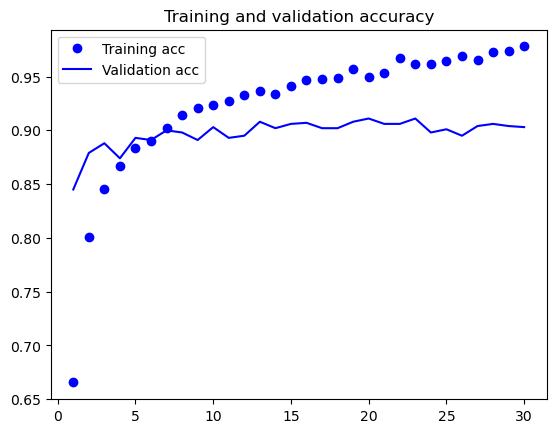

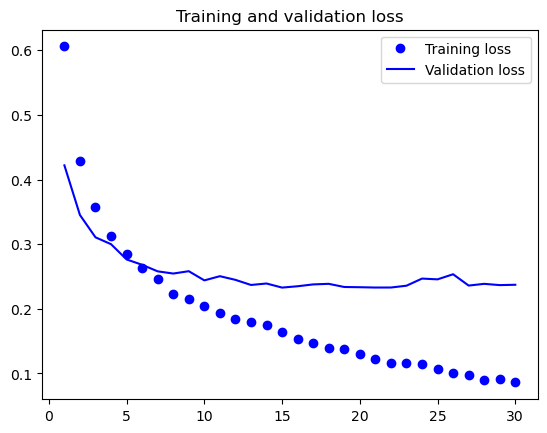

In [6]:
# 绘制训练期间的损失曲线和精度曲线
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Step 3：使用数据增强的特征提取

In [7]:
# 在卷积基上添加一个密集连接分类器

from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 冻结网络
conv_base.trainable = False

In [9]:
# 利用冻结的卷积基端到端地训练模型

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150), 
        batch_size=20,
        class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


C:\Users\HP\AppData\Local\Temp\ipykernel_6728\1124884079.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 135s 1s/step - loss: 0.5950 - acc: 0.6910 - val_loss: 0.4464 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 132s 1s/step - loss: 0.4915 - acc: 0.7630 - val_loss: 0.3817 - val_acc: 0.8330
Epoch 3/30
100/100 [==============================] - 131s 1s/step - loss: 0.4384 - acc: 0.7985 - val_loss: 0.3346 - val_acc: 0.8600
Epoch 4/30
100/100 [==============================] - 130s 1s/step - loss: 0.4019 - acc: 0.8220 - val_loss: 0.3135 - val_acc: 0.8650
Epoch 5/30
100/100 [==============================] - 131s 1s/step - loss: 0.3785 - acc: 0.8340 - val_loss: 0.3022 - val_acc: 0.8740
Epoch 6/30
100/100 [==============================] - 132s 1s/step - loss: 0.3680 - acc: 0.8345 - val_loss: 0.2931 - val_acc: 0.8780
Epoch 7/30
100/100 [==============================] - 137s 1s/step - loss: 0.3514 - acc: 0.8450 - val_loss: 0.2743 - val_acc: 0.8840
Epoch 8/30
100/100 [==============================] - 149s 1s/step - loss: 0.349

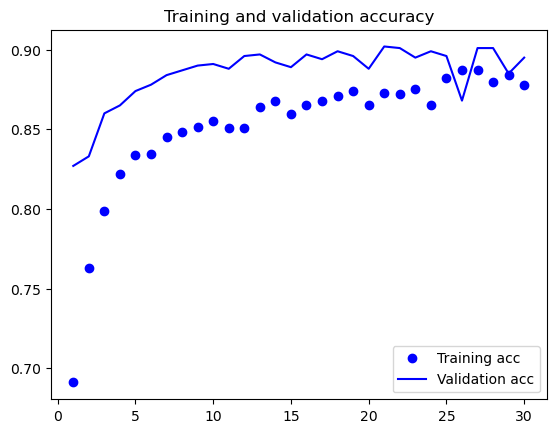

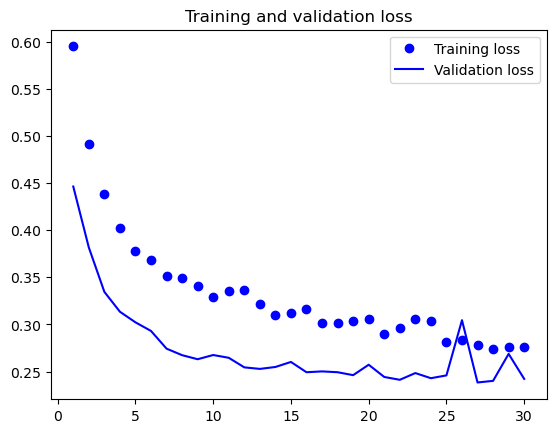

In [10]:
# 绘制结果
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Step 4：微调模型

In [12]:
# 冻结前几层
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 微调模型
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100


C:\Users\HP\AppData\Local\Temp\ipykernel_6728\3064131600.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 168s 2s/step - loss: 0.2914 - acc: 0.8735 - val_loss: 0.2267 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 161s 2s/step - loss: 0.2679 - acc: 0.8905 - val_loss: 0.2247 - val_acc: 0.9100
Epoch 3/100
100/100 [==============================] - 165s 2s/step - loss: 0.2371 - acc: 0.9040 - val_loss: 0.2508 - val_acc: 0.8970
Epoch 4/100
100/100 [==============================] - 166s 2s/step - loss: 0.2274 - acc: 0.9090 - val_loss: 0.2134 - val_acc: 0.9200
Epoch 5/100
100/100 [==============================] - 166s 2s/step - loss: 0.2092 - acc: 0.9115 - val_loss: 0.2010 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 166s 2s/step - loss: 0.1976 - acc: 0.9100 - val_loss: 0.1874 - val_acc: 0.9260
Epoch 7/100
100/100 [==============================] - 162s 2s/step - loss: 0.1892 - acc: 0.9225 - val_loss: 0.1905 - val_acc: 0.9270
Epoch 8/100
100/100 [==============================] - 162s 2s/step - loss

Epoch 62/100
100/100 [==============================] - 164s 2s/step - loss: 0.0249 - acc: 0.9920 - val_loss: 0.2595 - val_acc: 0.9400
Epoch 63/100
100/100 [==============================] - 164s 2s/step - loss: 0.0330 - acc: 0.9870 - val_loss: 0.2242 - val_acc: 0.9380
Epoch 64/100
100/100 [==============================] - 165s 2s/step - loss: 0.0255 - acc: 0.9890 - val_loss: 0.2468 - val_acc: 0.9340
Epoch 65/100
100/100 [==============================] - 164s 2s/step - loss: 0.0332 - acc: 0.9895 - val_loss: 0.2434 - val_acc: 0.9360
Epoch 66/100
100/100 [==============================] - 160s 2s/step - loss: 0.0232 - acc: 0.9935 - val_loss: 0.4167 - val_acc: 0.9160
Epoch 67/100
100/100 [==============================] - 160s 2s/step - loss: 0.0366 - acc: 0.9880 - val_loss: 0.3095 - val_acc: 0.9310
Epoch 68/100
100/100 [==============================] - 158s 2s/step - loss: 0.0168 - acc: 0.9950 - val_loss: 0.2339 - val_acc: 0.9440
Epoch 69/100
100/100 [==============================] -

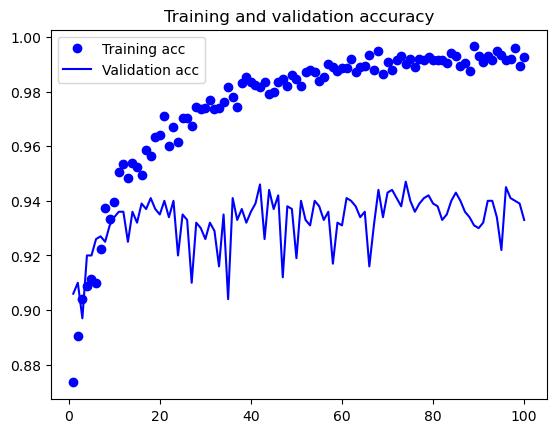

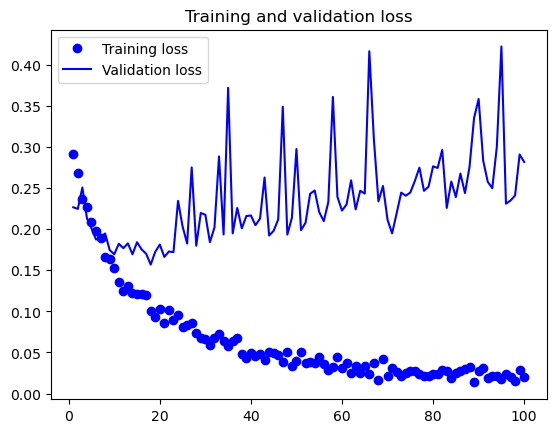

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\HP\AppData\Local\Temp\ipykernel_6728\3389064015.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9300000071525574
